In [15]:
# Loading Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as ttsplit
from scipy.stats import chi2_contingency
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize']=(10,8)

RANDOM_STATE = 53

In [16]:
# PATH
DATA_TRAIN_PATH = '../../data_v2/train.csv'
DATA_SCHOOL_PATH = '../../data_v2/user_educations.csv'

# CONSTANTS
SAMPLE_SIZE = int(2e4)

In [17]:
# Loading Data
df = pd.read_csv(DATA_TRAIN_PATH)
df.shape, df.head()

((903605, 2),
            from-to  score
 0    6320501-27657    0.0
 1  6310893-6295314    1.0
 2  6285646-6303434    3.0
 3   870193-6275811    1.0
 4  6270099-6270025    0.0)

In [18]:
# finding datatypes
df.dtypes

from-to     object
score      float64
dtype: object

In [19]:
#Separating the `from-to` column
temp = np.array(df['from-to'].apply(lambda x: x.split('-')).to_list())
df['userA_id'] = temp[:, 0]
df['userB_id'] = temp[:, 1]
df.head()

,from-to,score,userA_id,userB_id
0,6320501-27657,0.0,6320501,27657
1,6310893-6295314,1.0,6310893,6295314
2,6285646-6303434,3.0,6285646,6303434
3,870193-6275811,1.0,870193,6275811
4,6270099-6270025,0.0,6270099,6270025


In [20]:
# Checking types again
df.dtypes

from-to      object
score       float64
userA_id     object
userB_id     object
dtype: object

In [21]:
# Fixing type variables
type_correction = {'score': 'object',
                  }
df = df.astype(type_correction)

In [22]:
# Missing Value Proportions
np.round(df.isnull().sum()/df.shape[0] * 100, 2)

from-to     0.0
score       0.0
userA_id    0.0
userB_id    0.0
dtype: float64

In [23]:
# Count of Uniuqe Categories
df.nunique()

from-to     903605
score            4
userA_id     34833
userB_id     33689
dtype: int64

 **Important**
 
 - no duplicate rows present because unique `from-to` is in accord with no. of observations.

In [24]:
# Proportions of output labels
df['score'].value_counts(normalize=True)*100

0.0    49.939741
1.0    45.036935
3.0     4.167861
2.0     0.855462
Name: score, dtype: float64

In [25]:
# Subsetting Dataset to balance the output labels
df_label_3 = df[df['score'] == 3]
df_label_2 = df[df['score'] == 2]
df_label_1 = df[df['score'] == 1]
df_label_0 = df[df['score'] == 0]

# getting least freq label count
sample_size = min(df_label_3.shape[0],
    df_label_2.shape[0],
    df_label_1.shape[0],
    df_label_0.shape[0]) - 1

# Randomly selecting observations such that the classes are balanced
df_label_3, _ = ttsplit(df_label_3, random_state=RANDOM_STATE, train_size=sample_size)
df_label_2, _ = ttsplit(df_label_2, random_state=RANDOM_STATE, train_size=sample_size)
df_label_1, _ = ttsplit(df_label_1, random_state=RANDOM_STATE, train_size=sample_size)
df_label_0, _ = ttsplit(df_label_0, random_state=RANDOM_STATE, train_size=sample_size)


In [26]:
# merging the parts
parts = [df_label_3, df_label_2, df_label_1, df_label_0]
df_train = pd.concat(parts)
df_train = shuffle(df_train, random_state=RANDOM_STATE)

In [27]:
# Rechecking proportions
df_train['score'].value_counts(normalize=True)*100

3.0    25.0
2.0    25.0
1.0    25.0
0.0    25.0
Name: score, dtype: float64

In [28]:
# No. of uniuqe users for whom the relations are defined
len(set(df_train['userA_id'].to_list() +df_train['userB_id'].to_list()))

15583

In [29]:
# What is statistics of number of realtions defined for a user in the given data?
df = df_train['userA_id'].value_counts().values
df = np.append(df, df_train['userB_id'].value_counts().values)
pd.DataFrame(df).describe().T

,count,mean,std,min,25%,50%,75%,max
0,22116.0,2.795804,4.519357,1.0,1.0,1.0,3.0,289.0


- atmost 3 relations are given for the 75% of the user group
- maximum relation given for a user is 289

In [31]:
# Sampling the data
df_train.shape

(30916, 4)

## Relation against the user_school_id to the score of matchmaking(MM) / compatibility

In [32]:
# Loading school_id
df_school = pd.read_csv(DATA_SCHOOL_PATH)
df_school.head()

,user_id,school_id,degree_id
0,151,11825.0,2.0
1,151,13556.0,NaN
2,41,11929.0,1.0
3,41,13087.0,NaN
4,51,999999.0,NaN


Considering insgihts from the UA of `df_school`
 - `degree_id` had 99% of missing values and need to be dropped

In [33]:
# dropping `degree_id`
df_school.drop('degree_id', axis=1, inplace=True)
df_school.head()

,user_id,school_id
0,151,11825.0
1,151,13556.0
2,41,11929.0
3,41,13087.0
4,51,999999.0


In [34]:
# Grouping the schools by user_id
df_school_grouped = df_school.groupby('user_id')

In [35]:
# Accessing the schools of particular user
df_school_grouped.get_group(151)

,user_id,school_id
0,151,11825.0
1,151,13556.0


In [36]:
# Another user schools
df_school_grouped.get_group(41)

,user_id,school_id
2,41,11929.0
3,41,13087.0


In [37]:
# Utility function to lookup values in `df_school_grouped`
def get_common_schools(userA, userB):
    """
    Lookup group of schools for userA and userB
    
    Returns
        has_common_school: boolean: whether the users have common school
        n_common_school: int: count of schools common between the users
    """
    userA = int(userA)
    userB = int(userB)
    #
    # try block if no school info is present
    try:
        # feteching schools 
        uA_schools = set(df_school_grouped.get_group(userA)['school_id'].values)
        uB_schools = set(df_school_grouped.get_group(userB)['school_id'].values)
        commons = uA_schools.intersection(uB_schools)
        #
        # if school info has only 999999 (i.e. the group of less freq schools)
        if ( 999999 in commons) and (len(commons - {999999, }) <1):
            return True, -2
        # else find the common schools expect
        n_common_school = len( commons-{999999, })
        has_common_school = True if n_common_school > 0 else False
    # when no school information is present
    except Exception as e:
        return False, -1
    return has_common_school, n_common_school

# Testing the function
# get_common_schools(151, 17511)
# get_common_schools(51, 5371)
# get_common_schools(151, 41)

In [38]:
# Generating Features
temp = df_train.apply(lambda x: get_common_schools(x.userA_id, x.userB_id),
                  axis=1)
temp = np.array(temp.to_list())
df_train['has_common_school'] = temp[:, 0] 
df_train['n_common_school'] = temp[:, 1]

In [39]:
# Preview of new features
df_train.head()

,from-to,score,userA_id,userB_id,has_common_school,n_common_school
88555,4769697-6308211,3,4769697,6308211,0,-1
327058,2227465-17278,3,2227465,17278,0,0
692370,31105-531,2,31105,531,0,-1
697281,24072-1012437,0,24072,1012437,1,-2
902348,829489-49256,2,829489,49256,0,0


In [40]:
# Statistics on features
df_relations = df_train

value = [len(df_relations[df_relations['n_common_school'] == -1]), 
         len(df_relations[df_relations['n_common_school'] == -2]),
         len(df_relations[df_relations['n_common_school'] == 1]),
         len(df_relations[df_relations['n_common_school'] == 0]),
        ]

sample_size = df_relations.shape[0]
data = [
    ('DESCRIPTION', 'Proportion', 'N'),
    ('No school info', value[0] *100/ sample_size, value[0]),
    ('Part of only rare school', value[1] *100/sample_size, value[1]),
    ('Having Common Schools', value[2] *100/ sample_size, value[2]),
    ('Not having common schools', value[3] *100/ sample_size, value[3]),
]
print(tabulate(data, headers='firstrow'))

DESCRIPTION                  Proportion      N
-------------------------  ------------  -----
No school info                 19.663     6079
Part of only rare school       14.9955    4636
Having Common Schools           1.32941    411
Not having common schools      63.9281   19764


---
### Is there a relation between belonging to same school and having compatibility?

In [41]:
df_train.head()

,from-to,score,userA_id,userB_id,has_common_school,n_common_school
88555,4769697-6308211,3,4769697,6308211,0,-1
327058,2227465-17278,3,2227465,17278,0,0
692370,31105-531,2,31105,531,0,-1
697281,24072-1012437,0,24072,1012437,1,-2
902348,829489-49256,2,829489,49256,0,0


In [42]:
# Creating contingency table
school_v_score = pd.crosstab(df_train['has_common_school'], df_train['score'], margins=True)
school_v_score

score,0.0,1.0,2.0,3.0,All
has_common_school,,,,,
0,6509,6550,6332,6452,25843
1,1220,1179,1397,1277,5073
All,7729,7729,7729,7729,30916


In [43]:
# Stats value
tstat, p , dof, exp = chi2_contingency( school_v_score)
print(f'pValue : {p}')

pValue : 0.0013201457228449928


- $p-Value = 0.0013 < 0.05$(critical_value) therefore we safetly 

this implies that there is strong evidence against the $H_0$ hypothesis.
Hence we can reject the 
$H_0$ : there is not relationship between belonging to common school and compatibility of users.

CONCLUSION : `has_common_school` can be used as predictor variable as statiscally verified that there exists relationship between belonging to same school and compatibility.

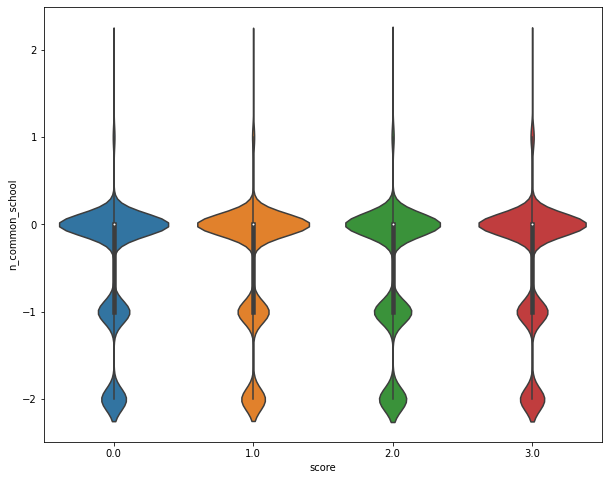

In [47]:
# Distribution of n_common_schools vs scores
sns.violinplot(data=df_train,
           x='score',
           y='n_common_school')

- distribution of `n_common_school` is same for all compatibility levels, hence cannot be a good predictor